In [1]:
!pip install bokeh
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

warnings.filterwarnings('ignore')
output_notebook()

def h_blend_optimized(params, details=False, output_name='ensemble_sub.csv'):
    # 1. Load and Merge Data
    path = params['path']
    id_col, target_col = params['id_target']
    
    dfs = []
    subm_names = [s['name'] for s in params['subm']]
    for name in subm_names:
        df_temp = pd.read_csv(f"{path}{name}.csv")[[id_col, target_col]]
        dfs.append(df_temp.rename(columns={target_col: name}).set_index(id_col))
    
    df_subms = pd.concat(dfs, axis=1)
    
    # 2. Weighted Rank Blending Logic
    def get_blend(df, direction):
        vals = df[subm_names].values
        main_w = np.array([s['weight'] for s in params['subm']])
        pos_w = np.array(params['subwts'])
        
        # Sort indices row-wise
        ranks = np.argsort(-vals if direction == 'desc' else vals, axis=1)
        
        blended = np.zeros(vals.shape[0])
        for i in range(len(subm_names)):
            col_idx = ranks[:, i]
            row_idx = np.arange(len(vals))
            # Calculate: Value * (Base Weight of that model + Weight of that rank position)
            blended += vals[row_idx, col_idx] * (main_w[col_idx] + pos_w[i])
        return blended

    desc_blend = get_blend(df_subms, 'desc')
    asc_blend = get_blend(df_subms, 'asc')
    
    # Apply global asc/desc weights
    w_asc, w_desc = params['type_sort'][1], params['type_sort'][2]
    final_pred = (w_desc * desc_blend) + (w_asc * asc_blend)
    
    df_final = df_subms.copy()
    df_final[target_col] = final_pred
    
    # 3. Output
    df_out = df_final[[target_col]].reset_index()
    df_out.to_csv(output_name, index=False)
    
    # 4. Diagnostics (The 'details' logic)
    if details:
        print("Ensemble Summary Statistics:")
        print(df_out[target_col].describe())
        
        plt.figure(figsize=(12, 5))
        for name in subm_names:
            sns.kdeplot(df_subms[name], label=f"Model: {name}", alpha=0.4)
        sns.kdeplot(final_pred, label='Final Ensemble', linewidth=3, color='black', linestyle='--')
        plt.title("Comparison of Model Distributions vs. Final Ensemble")
        plt.legend()
        plt.show()

    return df_out

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/7.2 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Loading BokehJS ...

Ensemble Summary Statistics:
count    1.447107e+06
mean    -8.631313e-01
std      3.958448e+00
min     -7.201524e+01
25%     -1.348013e-01
50%     -2.305453e-03
75%      3.306881e-04
max      1.156980e+01
Name: prediction, dtype: float64


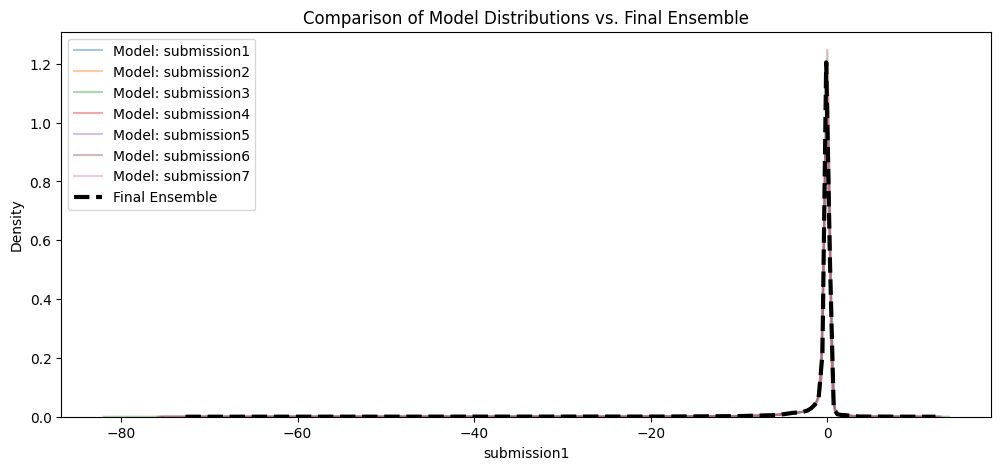

CPU times: user 2min 46s, sys: 1.53 s, total: 2min 47s
Wall time: 1min 3s


In [2]:
%%time

params = {
      # Ensure path matches standard Kaggle format or keep your custom path if verified
      'path'     : f'/kaggle/input/datasets/abhinavsharma0706/hedge-knight/',            
      'id_target': ['id',"prediction",],          
      'type_sort': ['asc/desc',0.30,0.70 ],
      # [PATCH 2: Expanded arrays to accommodate 7 datasets. Sum of subwts should remain near 0]
      'subwts'   : [w/100 for w in [ +12, +6, +3, -1, -4, -6, -10 ]],
      'subm'     : [
          # Added files for model regularization (weights sum to exactly 1.0)
          {'name': f'submission1', 'weight':+0.48, 'color':'orange'},
          {'name': f'submission2', 'weight':+0.01, 'color':'green'},
          {'name': f'submission3', 'weight':+0.02, 'color':'crimson'},
          {'name': f'submission4', 'weight':+0.04, 'color':'darkgray'},
          {'name': f'submission5', 'weight':+0.06, 'color':'silver'},
          {'name': f'submission6', 'weight':+0.14, 'color':'cyan'},
          {'name': f'submission7', 'weight':+0.25, 'color':'crimson'},]
}
df = h_blend_optimized(params, details=True)

# Cleanup
for file in ['cross.csv', 'tida_desc.csv']: 
    if os.path.exists(file): 
        os.remove(file)

In [3]:
df.to_csv('submission.csv',index=False)
df

,id,prediction
0,W2MW3G2L__495MGHFJ__PZ9S1Z4V__1__3647,-0.012012
1,W2MW3G2L__495MGHFJ__PZ9S1Z4V__1__3648,-0.013152
2,W2MW3G2L__495MGHFJ__PZ9S1Z4V__1__3649,-0.013666
3,W2MW3G2L__495MGHFJ__PZ9S1Z4V__1__3650,-0.016132
4,W2MW3G2L__495MGHFJ__PZ9S1Z4V__1__3651,-0.014727
...,...,...
1447102,83EG83KQ__VYN97209__PHHHVYZI__25__4279,0.000120
1447103,83EG83KQ__VYN97209__PHHHVYZI__25__4280,-0.000130
1447104,83EG83KQ__VYN97209__PHHHVYZI__25__4281,-0.000165
1447105,83EG83KQ__VYN97209__PHHHVYZI__25__4282,-0.000177
